# 聚类算法：将k-means用于色彩压缩

## 1 应用背景

- 设想有一幅包含几百万种颜色的图像，但其实大多数图像中的很大一部分色彩通常是不会被眼睛注意到的，而且图像中的很多像素都拥有类似或者相同的颜色，可以用聚类算法实现图像色彩压缩
- test some changes
## 2 代码实现  

### （1）输入图像

- 该图像来源于Scikit-Learn的datasets模块

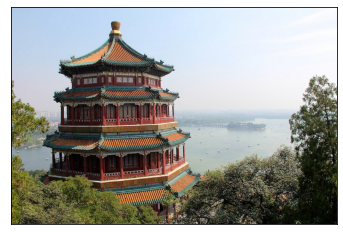

In [9]:
from sklearn.datasets import load_sample_image #需要安装pillow图像程序包
import matplotlib.pyplot as plt
import numpy as np
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[],yticks=[])
ax.imshow(china)


### （2）像素可视化

- 图像存储在一个三维数组(height, width, RGB)中，以0～255的整数表示红/蓝/绿信息


In [5]:
china.shape 

(427, 640, 3)

- 将这组像素转换成三维颜色空间中的一群数据点，先缩放颜色至其取值为0～1，然后将数据变形为[n_sample * n_features]

In [7]:
data = china/255.0 #转换成0～1区间值
data = data.reshape(427*640,3)
data.shape

(273280, 3)

- 对像素进行可视化（为演示方便此处只使用包含前10000个像素的子集）
- 有关np.random.permutation()的说明参见 https://blog.csdn.net/zhlw_199008/article/details/80569167

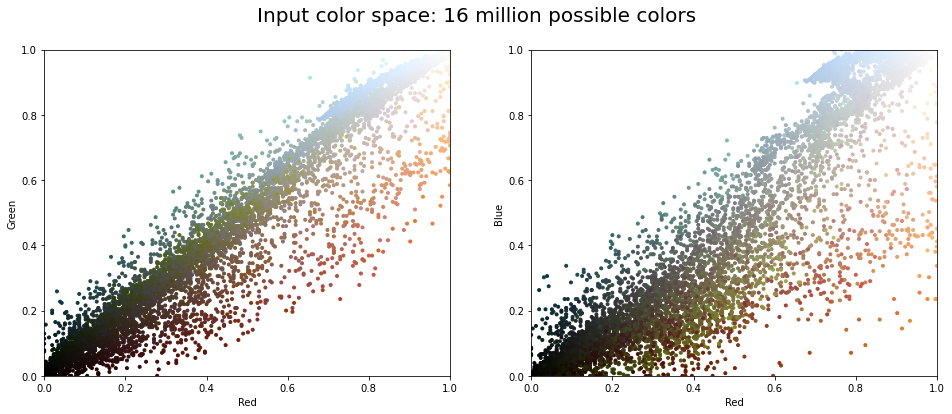

In [12]:
def plot_pixels(data, title, colors = None, N=10000):
    if colors is None:
        colors = data

    #随机选择一个子集
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N] #输出10000个273280内的随机数
    colors = colors[i]
    R,G,B = data[i].T

    fig, ax = plt.subplots(1,2,figsize=(16,6)) #两个分面
    ax[0].scatter(R,G,color=colors,marker='.')
    ax[0].set(xlabel='Red',ylabel='Green',xlim=(0,1),ylim=(0,1))

    ax[1].scatter(R,B,color=colors,marker='.')
    ax[1].set(xlabel='Red',ylabel='Blue',xlim=(0,1),ylim=(0,1))

    fig.suptitle(title, size=20)

plot_pixels(data,title='Input color space: 16 million possible colors')


### (3) 对像素空间聚类

- 对像素空间（特征矩阵）适用k-means聚类，将1600万种颜色（255*255*255=16581375）缩减到16种颜色；
- 因为处理的是一个非常大的数据集，所以使用MiniBatchKMeans算法对数据集的子集进行计算，这种算法比标准的k-means算法速度更快，MiniBatchKMeans 是 KMeans 算法的一个变种，它使用小批量(mini-batches)来减少计算时间，而这多个批次仍然尝试优化相同的目标函数。小批量是输入数据的子集，在每次训练迭代中随机抽样。这些小批量大大减少了收敛到局部解所需的计算量。 与其他降低 k-means 收敛时间的算法不同，小批量 k-means 产生的结果通常只比标准算法略差，更多关于该算法的内容参见 https://sklearn.apachecn.org/#/docs/master/22?id=mean-shift

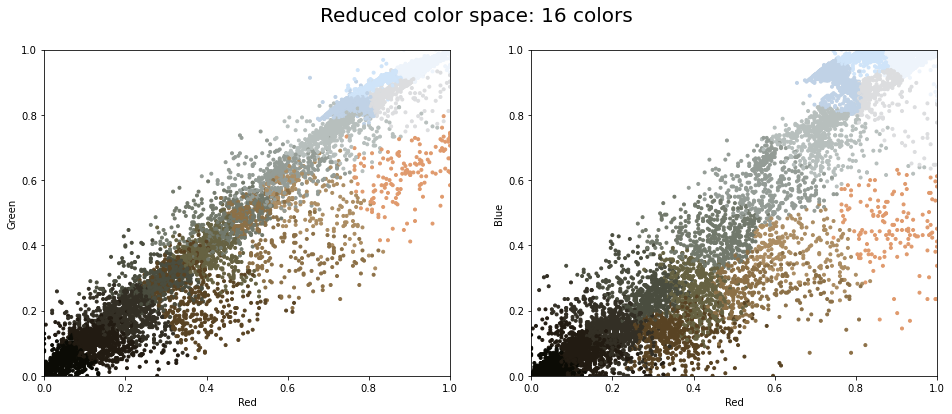

In [13]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16) #设置聚类数
kmeans.fit(data) #学习训练数据的cluster
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]#每个像素被指定为距离其最近的簇中心点的颜色

#作图,在RGB颜色空间中16类
plot_pixels(data,colors=new_colors,title='Reduced color space: 16 colors')

### （4）生成16个颜色的图像

- 用计算的结果对原始像素重新着色，即每个像素被指定为距离其最近的簇中心点的颜色，用新的颜色在图像空间（427*640）画图

Text(0.5, 1.0, '16-color Image')

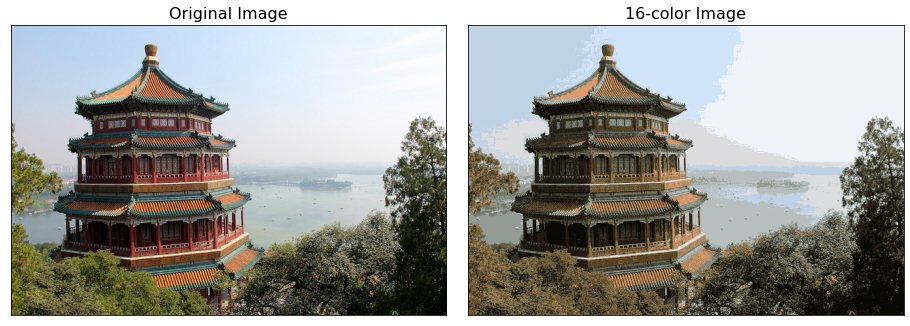

In [15]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1,2,figsize=(16,6),subplot_kw=dict(xticks=[],yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image',size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image',size=16)




- 虽然右图丢失了某些细节，但图像总体上还是非常容易辨识，且实现了将近一百万的压缩比。